In [ ]:
Практическая работа № 3

Выполнил студент группы ББМО-01-23: Буланов Андрей Алексеевич

Цель работы:

1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки Carlini-Wagner.
3. Реализовать атаку CW с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.

In [1]:
!pip install foolbox


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.9723 - loss: 0.0923
Test accuracy on clean images: 0.9758999943733215


tf.Tensor(7, shape=(), dtype=int64)


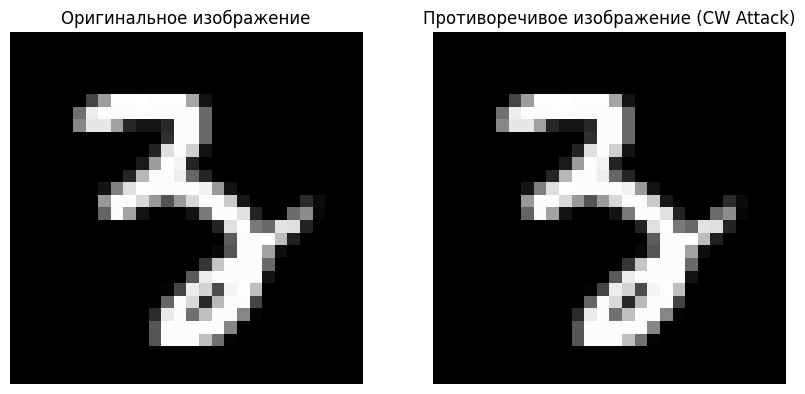

In [25]:
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git 
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

image = tf.convert_to_tensor(test_images[87], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

In [32]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []
batch_size = 32

# Обработка изображений пакетами
for i in range(0, len(test_images) // 10, batch_size):

    # Создаем пакет изображений и меток
    batch_images = tf.convert_to_tensor(test_images[i:i + batch_size], dtype=tf.float32)
    batch_labels = np.argmax(test_labels[i:i + batch_size], axis=1)
    batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    # Проверка размерности
    advs, _, success = attack(fmodel, batch_images, batch_labels, epsilons=0.1)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:len(adversarial_images)])
print(f'Точность на состязательных примерах (атака CW): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0847 - loss: 2.2000 
Точность на состязательных примерах (атака CW): 0.0771484375


Вывод

Точность модели на атакованных примерах значительно снизилась, что указывает на её неспособность корректно распознавать изображения при наличии целенаправленных, минимальных искажений. Это подчеркивает необходимость разработки более устойчивых моделей и использования методов защиты от атак для повышения надежности в практических приложениях.